Importing libraries

In [1]:
import os
import sys
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

torch.backends.cudnn.deterministic = True

In [2]:
# checking cuda availability

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cuda device.


In [ ]:
# set the standard for every images to be trained

class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [4]:
transform = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

In [5]:
train_dir = './train'

In [6]:
dataset = datasets.ImageFolder(root = train_dir, transform=transform)

In [7]:
dataset.classes

['blank', 'hog']

In [8]:
len(dataset)

3191

In [11]:
dataset[0][0].shape

torch.Size([3, 224, 224])

In [12]:
batch_size = 32
dataset_loader = DataLoader(dataset, batch_size=batch_size)

# Get one batch
first_batch = next(iter(dataset_loader))

print(f"Shape of one batch: {first_batch[0].shape}")
print(f"Shape of labels: {first_batch[1].shape}")

Shape of one batch: torch.Size([32, 3, 224, 224])
Shape of labels: torch.Size([32])


In [14]:
# splitting the training and testing dataset

train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])

In [17]:
def class_counts(dataset):
    c = Counter(x[1] for x in dataset)
    class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})

In [18]:
class_counts(train_dataset)

blank    1769
hog       784
dtype: int64

In [19]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [20]:
# creating the model architecture

model_seq = torch.nn.Sequential()

conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
model_seq.append(conv1)

model_seq.append(torch.nn.ReLU())
model_seq.append(torch.nn.MaxPool2d(kernel_size=2, stride=2))

conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
model_seq.append(conv2)
model_seq.append(torch.nn.ReLU())
model_seq.append(torch.nn.MaxPool2d(kernel_size=2, stride=2))

conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
model_seq.append(conv3)
model_seq.append(torch.nn.ReLU())
model_seq.append(torch.nn.MaxPool2d(kernel_size=2, stride=2))

model_seq.append(torch.nn.Flatten())

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
)

In [21]:
summary(model_seq, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 50176]               --
├─Conv2d: 1-1                            [32, 16, 224, 224]        448
├─ReLU: 1-2                              [32, 16, 224, 224]        --
├─MaxPool2d: 1-3                         [32, 16, 112, 112]        --
├─Conv2d: 1-4                            [32, 32, 112, 112]        4,640
├─ReLU: 1-5                              [32, 32, 112, 112]        --
├─MaxPool2d: 1-6                         [32, 32, 56, 56]          --
├─Conv2d: 1-7                            [32, 64, 56, 56]          18,496
├─ReLU: 1-8                              [32, 64, 56, 56]          --
├─MaxPool2d: 1-9                         [32, 64, 28, 28]          --
├─Flatten: 1-10                          [32, 50176]               --
Total params: 23,584
Trainable params: 23,584
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 4.44
Input size (MB): 19.27
Forward/backwa

In [22]:
model_seq.append(torch.nn.Dropout())
model_seq.append(torch.nn.Linear(64 * 28 * 28, 512))
model_seq.append(torch.nn.ReLU())
model_seq.append(torch.nn.Dropout())
model_seq.append(torch.nn.Linear(512, 128))
model_seq.append(torch.nn.ReLU())
model_seq.append(torch.nn.Dropout())
model_seq.append(torch.nn.Linear(128, 64))
model_seq.append(torch.nn.ReLU())
model_seq.append(torch.nn.Dropout())
model_seq.append(torch.nn.Linear(64, 2))

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=512, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=512, out_features=128, bias=True)
  (15): ReLU()
  (16): Dropout(p=0.5, inplace=False)
  (17): Linear(in_features=128, out_features=64, bias=True)
  (18): ReLU()
  (19): Dropout(p=0.5, inplace=False)
  (20): Linear(in_features=64, out_features=2, bias=True)
)

In [23]:
summary(model_seq, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 2]                    --
├─Conv2d: 1-1                            [1, 16, 224, 224]         448
├─ReLU: 1-2                              [1, 16, 224, 224]         --
├─MaxPool2d: 1-3                         [1, 16, 112, 112]         --
├─Conv2d: 1-4                            [1, 32, 112, 112]         4,640
├─ReLU: 1-5                              [1, 32, 112, 112]         --
├─MaxPool2d: 1-6                         [1, 32, 56, 56]           --
├─Conv2d: 1-7                            [1, 64, 56, 56]           18,496
├─ReLU: 1-8                              [1, 64, 56, 56]           --
├─MaxPool2d: 1-9                         [1, 64, 28, 28]           --
├─Flatten: 1-10                          [1, 50176]                --
├─Dropout: 1-11                          [1, 50176]                --
├─Linear: 1-12                           [1, 512]                  25,690,624

In [24]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_seq.parameters(), lr=0.001)
model_seq.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=512, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=512, out_features=128, bias=True)
  (15): ReLU()
  (16): Dropout(p=0.5, inplace=False)
  (17): Linear(in_features=128, out_features=64, bias=True)
  (18): ReLU()
  (19): Dropout(p=0.5, inplace=False)
  (20): Linear(in_features=64, out_features=2, bias=True)
)

In [26]:
def train_epochs(model, optimizer, loss_fn, data_loader, device = 'cpu'):

    training_loss = 0.0
    model.train()

    for inputs, targets in data_loader:
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        training_loss += loss.item() * inputs.size(0)

    return training_loss / len(data_loader.dataset)

In [36]:
for epoch in range(20):
    train_loss = train_epochs(model_seq, optimizer, loss_fn, train_loader, device)
    print(f"Epoch {epoch + 1}, Training Loss: {train_loss:.4f}")

Epoch 1, Training Loss: 0.1371
Epoch 2, Training Loss: 0.1239
Epoch 3, Training Loss: 0.0987
Epoch 4, Training Loss: 0.0955
Epoch 5, Training Loss: 0.0886
Epoch 6, Training Loss: 0.0767
Epoch 7, Training Loss: 0.0816
Epoch 8, Training Loss: 0.0874
Epoch 9, Training Loss: 0.0766
Epoch 10, Training Loss: 0.0558
Epoch 11, Training Loss: 0.0488
Epoch 12, Training Loss: 0.0459
Epoch 13, Training Loss: 0.0347
Epoch 14, Training Loss: 0.0303
Epoch 15, Training Loss: 0.0381
Epoch 16, Training Loss: 0.0296
Epoch 17, Training Loss: 0.0289
Epoch 18, Training Loss: 0.0472
Epoch 19, Training Loss: 0.0342
Epoch 20, Training Loss: 0.0291


In [30]:
import torch.nn.functional as F


In [28]:
# predict function usinf softmax

def predict(model, data_loader, device = 'cpu'):
    all_probs = torch.tensor([]).to(device)
    model.eval()

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            all_probs = torch.cat((all_probs, probs), dim=0)
    return all_probs

In [37]:
train_predicts = torch.argmax(predict(model_seq, train_loader, device), dim=1)

In [38]:
train_predicts

tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')

In [39]:
targets_train = torch.cat([labels for _, labels in train_loader]).to(device)
is_correct_train = torch.eq(train_predicts, targets_train)
total_correct_train = torch.sum(is_correct_train).item()
accuracy_train = total_correct_train / len(train_loader.dataset)

print(f"Accuracy on the training data: {accuracy_train}")

Accuracy on the training data: 0.5746180963572268


In [40]:
val_predicts = torch.argmax(predict(model_seq, test_loader, device), dim=1)

In [41]:
targets_val = torch.cat([labels for _, labels in test_loader]).to(device)
is_correct_val = torch.eq(val_predicts, targets_val)
total_correct_val = torch.sum(is_correct_val).item()
accuracy_val = total_correct_val / len(test_loader.dataset)

print(f"Accuracy on the validation data: {accuracy_val}")

Accuracy on the validation data: 0.9702194357366771


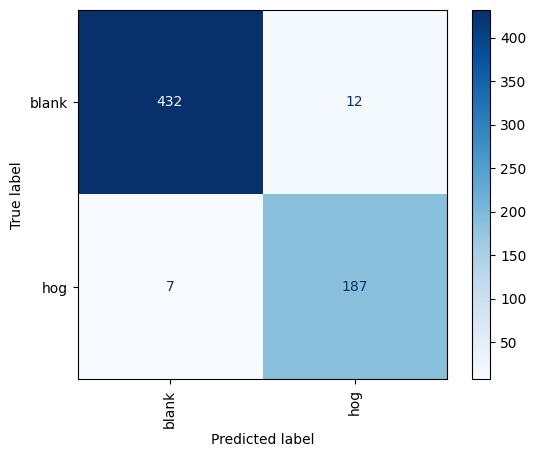

In [42]:
cm = confusion_matrix(targets_val.cpu(), val_predicts.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["blank", "hog"])

disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical");

In [43]:
# let's test

hog_img = os.path.join(train_dir, "hog")

In [56]:
import PIL.Image


img = PIL.Image.open(os.path.join(hog_img, os.listdir(hog_img)[45]))
img1 = PIL.Image.open(os.path.join(hog_img, os.listdir(hog_img)[4]))
img2 = PIL.Image.open(os.path.join(hog_img, os.listdir(hog_img)[5]))


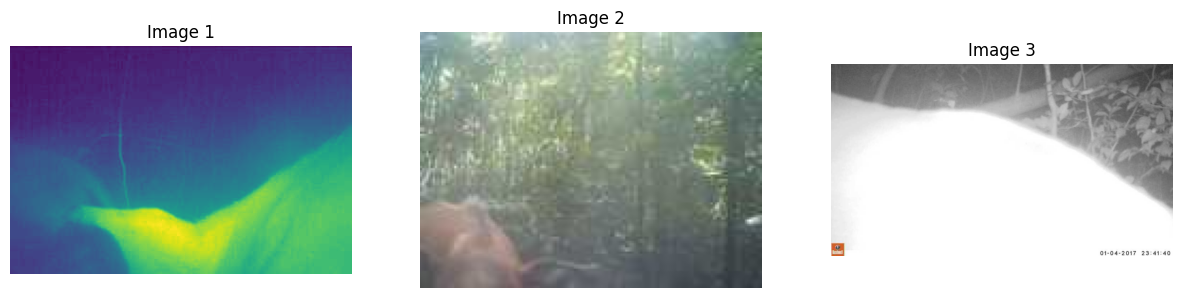

In [60]:
plt.figure(figsize=(15, 5))

# Display the first image
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.axis("off")
plt.title("Image 1")

# Display the second image
plt.subplot(1, 3, 2)
plt.imshow(img1)
plt.axis("off")
plt.title("Image 2")

# Display the third image
plt.subplot(1, 3, 3)
plt.imshow(img2)
plt.axis("off")
plt.title("Image 3")

plt.show()

In [54]:
img = transform(img).unsqueeze(0).to(device)

In [55]:
# 0--> blank, 1 --> hog

model_seq.eval()
predicted = torch.argmax(model_seq(img), dim=1)
predicted.item()

1